<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_(ch2_6_132_145)_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사이킷런으로 수행하는 타이타닉 생존자 예측

## 타이타닉 탑승자 데이터


> - Passengerid: 탑승자 데이터 일련번호
- survived : 생존여부 0=사망, 1=생존 (생존자 예측이므로, target이 될 것)
- pclass: 선실 등급 1=일등석, 2=이등석, 3=삼등석
- sex: 탑승자 성별
- name: 탑승자 이름
- Age: 탑승자 나이
- sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
- parch: 같이 탑승한 부모님 또는 어린이 인원수
- ticket: 티켓 번호
- fare: 요금
- cabin: 선실 번호
- embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southampton


1. 분석에 필요한 라이브러리 import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline  
# 그래프가 출력되도록 함

2. 판다스를 이용해 타이타닉 탑승자 파일을 DataFrame으로 로딩

In [3]:
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/session/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


3. 로딩된 데이터의 칼럼 타입 확인

In [4]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


- RangeIndex(891): 데이터 프레임의 인덱스 범위를 나타냄 -> 전체 행의 개수를 알 수 있게 해준다. 
- 12개의 열이 존재: 2개의 칼럼이 float, 5개가 int, 5개가 object(string이라고 생각하면 됨) 
- Age, Cabin, Embarked 열은 각각 714개, 204개, 889개의 non-null 값을 갖고 있으므로, null 값을 갖고 있음 -> 사이킷런 머신러닝 알고리즘은 null 값을 허용하지 않으므로 전처리 필요


4. null값 전처리: fillna() 함수를 이용하여 평균 또는 고정 값으로 변경

In [5]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값의 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값의 개수  0


5. 문자열 피처들의 값 분류 확인: Sex, Cabin, Embarked

In [6]:
print('Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 : \n', titanic_df['Embarked'].value_counts())

Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 : 
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


- 선실번호의 경우, 이전 null값을 채운 것이 많은 것도 특이하고 속성값이 제대로 정리되지 않았다는 것도 알 수 있음(여러개의 선실이 한 번에 표시되어 있는 등)
- 선실번호에서 중요한 것은 앞자리의 선실 등급이므로, 앞 문자만 추출할 것

6. 선실 번호의 앞 문자열만 추출하여 선실 등급을 알아보기

In [7]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


- 알고리즘 적용 전 예측을 수행하기 전에 데이터를 먼저 탐색

1. 어떤 유형의 승객이 생존 확률이 높았는지 확인해보기: 성별에 따른 생존 확률

In [8]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count() # 0이 사망, 1이 생존

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

- 탑승객 수) 남자: 577명, 여자 314명
- 여성 생존률: 233/314 = 74.2%
- 남성 생존률: 109/577 = 18.8%


2. 위 결과를 시각화: X축에 Sex 칼럼, Y축에 Survived 칼럼

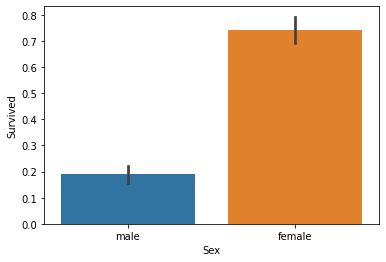

In [9]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

3. 부에 따른 생존 확률: 객실 등급별, 성별에 따른 생존 확률

> x 좌표에 'Pclass', y 좌표에 'Survived', hue = 'Sex'



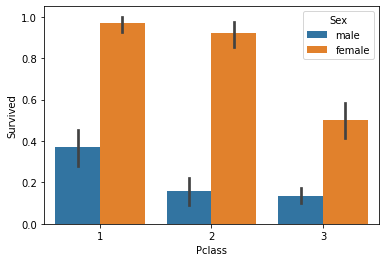

In [10]:
sns.barplot(x='Pclass', y='Survived', hue = 'Sex',data=titanic_df)

- 여성의 경우 1,2등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐
- 남성의 경우는 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 원등히 높음

In [11]:
# 그냥 궁금해서 해봄
titanic_df.groupby(['Sex','Survived','Pclass'])['Survived'].count() 

Sex     Survived  Pclass
female  0         1           3
                  2           6
                  3          72
        1         1          91
                  2          70
                  3          72
male    0         1          77
                  2          91
                  3         300
        1         1          45
                  2          17
                  3          47
Name: Survived, dtype: int64

3. Age에 따른 생존 확률: Age 카테고리 할당 및 시각화

In [13]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용. 
def get_category(age):
  cat = ''
  if age <= -1 : cat = "Unknown"
  elif age <= 5 : cat = "Baby"
  elif age <= 12 : cat = 'Child'
  elif age <= 18 : cat = "Teenager"
  elif age <= 25 : cat = "Student"
  elif age <= 35 : cat = "Young Adult"
  elif age <= 60 : cat = "Adult"
  else : cat = "Elderly"

  return cat

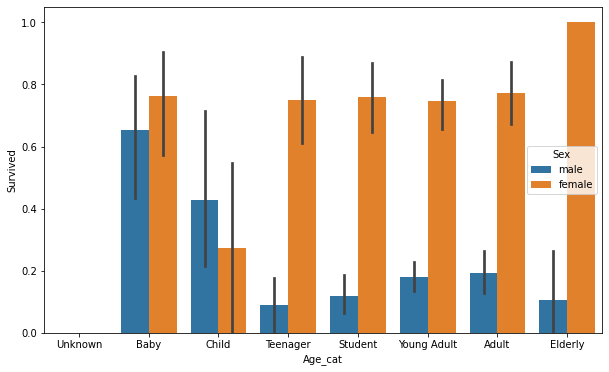

In [15]:
# 막대 그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True) # 'Age_cat'열을 지운다. 

- 여자 baby의 경우는 비교적 생존 확률이 높음
- 여자 children은 상대적으로 생존 확률이 낮음
- 여자 Elderly의 경우는 생존 확률이 매우 낮음
- 이제까지의 분석 결과 연령, 성별, 객실 등급이 중요한 생존 피처임으로 알 수 있다. 

4. 남아있는 문자열 카테고리 피처를 숫자형 피처로 변환: 사이킷런의 LabelEncoder(카테고리 값의 유형 수에 따라 0~(카테고리 유형 수 -1)까지의 숫자 값으로 변환)

In [16]:
from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder() # label 인코더를 넣고
    le = le.fit(dataDF[feature]) # 데이터 프레임의 각 열을 fitting함 
    dataDF[feature] = le.transform(dataDF[feature]) # 데이터 프레임에 피팅해서 변환한 것을 반영
  
  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


5. 피처를 가공한 내역을 정리하고 이를 함수로 만들어 쉽게 재사용할 수 있도록하기: transform_features()

In [17]:
# Null 처리 함수

def fillna(df):
  df['Age'].fillna(df['Age'].mean(),inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0, inplace=True)

  return df

In [18]:
# 머신러닝 알고리즘에 불필요한 속성 제거

def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True) # 해당 열을 제거
  return df

In [23]:
# 레이블 인코딩 수행

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder() # label 인코더를 넣고
    le = le.fit(df[feature]) # 데이터 프레임의 각 열을 fitting함 
    df[feature] = le.transform(df[feature]) # 데이터 프레임에 피팅해서 변환한 것을 반영
  return df

In [24]:
# 앞에서 설정한 데이터 전처리 함수를 모두 호출하는 함수 생성 
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

6. transform_features() 함수를 이용해 원본 데이터 가공

> 1. 원본 파일 다시 불러와서 로딩
2. 생존자 데이터 세트의 레이블인 survived 속성만 분리해 클래스 결정값 데이터 세트로 만든다. 
3. Survived 속성을 drop해서 feature 데이터세트를 만든다. 
4. feature 데이터 세트에 transform_feature 를 적용해 데이터를 가공한다. 



In [25]:
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/session/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

7. 내려받은 데이터 세트 기반으로 train_test_split()으로 별도의 테스트 데이터세트를 추출: 크기 20%

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2,
                                                    random_state=11)

8. 생존자 예측: ML 알고리즘인 1) 결정트리 2) 랜덤 포레스트 3) 로지스틱 회귀

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 사이킷런 Classifier 클래스 생성 
dt_clf = DecisionTreeClassifier(random_state=11) # 결정트리 
rf_clf = RandomForestClassifier(random_state=11) # 랜덤포레스트
lr_clf = LogisticRegression() # 로지스틱 회귀

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train) # 모델을 fitting 함
dt_pred = dt_clf.predict(X_test) # 모델로 테스트 데이터를 예측함
print("DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, dt_pred))) # 실제로 얼마나 맞는지 확인해봄

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print("RandomForestClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, rf_pred)))

# LogisticRegression
lr_clf.fit(X_train, y_train)
lr_pred =lr_clf.predict(X_test)
print("DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
DecisionTreeClassifier 정확도 : 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 로지스틱 회귀가 가자 ㅇ높은 정확도를 보여주고 있음.
- 아직 최적화 작업 수행 전, 데이터도 부족하므로 가장 성능이 좋은 알고리즘이 뭐지 평가 불가능

9. 교차 검증으로 결정트리 모델을 좀 더 평가하기


> model_selection패키지의 KFold 클래스, cross_val_score(), GridSearchCV 클래스를 모두 사용



KFold 클래스로 교차 검증

In [29]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
  # 폴드 세트를 5개인 KFold객체를 생성, 포드 수만큼 예측 결과 저장을 위한 리스트 객체 생성
  kfold = KFold(n_splits=folds)
  scores=[]

  # KFold 교차 검증 수행
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
  
  # 5개 fold에서의 평균 정확도 계산
  mean_score = np.mean(scores)
  print("평균 정확도: {0:.4f}".format(mean_score))

# exec)kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


cross_val_score()

In [30]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)

for iter_count, accuracy in enumerate(scores):
  print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))


print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


- 위 둘의 결과가 다른 이유는, cross_val_score()는 StraitfiedKFold를 이용해 세트를 분할함

GridSearchCV


> DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 서능을 측정






In [31]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5], 
              'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearchCV 최적 하이퍼 파라미터 :", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
